In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader

In [2]:
def csv_to_tensor(csv_path, lag_time = 1, normalize = False):
    """Function to convert csv file to tensor Dataset, required to create data loader
    
    Arguments:
        csv_path (str): Path to csv file 
        lag_time (int): Choosen lag time (to create inputs and targets)
        normalize (bool): normalize data in each column separately (y = (x - x.mean) / x.std) - default True
    """
    #read data form csv
    data = pd.read_csv(csv_path)
    #drop unnecessary columns
    data = data.drop(columns=['time', 'phi', 'psi', 'theta'])
    #normalize columns if required to
    if normalize:
        for col in data:
            data[col] = (data[col] - data[col].mean()) / data[col].std()
    #convert to numpy array
    data_np = data.values
    #create inputs and targets with respect to choosen lag time
    x = data_np[:-lag_time, :]
    y = data_np[lag_time:, :]
    
    return torch.utils.data.TensorDataset(torch.from_numpy(np.float32(x)), torch.from_numpy(np.float32(y)))

In [200]:
data_dict = {
            'nt1':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 1, normalize=True),
            'nt2':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 2, normalize=True),
            'nt3':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 3, normalize=True),
            'nf1':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 1, normalize=False),
            'nf2':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 2, normalize=False),
            'nf3':csv_to_tensor(csv_path='../../ala2_.csv', lag_time = 3, normalize=False),
}
            

In [162]:
class AE(torch.nn.Module):
    def __init__(self, input_size = 21, lattent_size = 2, hidden_size = []):
        super(AE, self).__init__()
        self.sizes = [input_size] + hidden_size + [lattent_size]
        
        #Create all layers for encoder
        for idx, val in enumerate(range(1, len(self.sizes))):
            setattr(self, 'enc%d' % idx, nn.Linear(self.sizes[val - 1], self.sizes[val]))
            
        #Create all layers for decoder
        for idx, val in enumerate(reversed(range(1, len(self.sizes)))):
            setattr(self, 'dec%d' % idx, nn.Linear(self.sizes[val], self.sizes[val - 1]))
    
    def encode(self, x):
        y = x
        for idx in range(len(self.sizes)-2):
            #apply activation layer
            y = F.leaky_relu(getattr(self, 'enc%d' % idx)(y))
        return getattr(self, 'enc%d' % (len(self.sizes)-2))(y)
    
    def decode(self, x):
        y = x
        for idx in range(len(self.sizes)-1):
            #apply activation layer
            y = F.leaky_relu(getattr(self, 'dec%d' % idx)(y))
        return y
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)

In [229]:
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs):
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        loss = 0.0
        valid_loss = 0.0
        model.train()
        for inputs, targets in train_loader:
            #reset gradients
            optimizer.zero_grad()
            #compute reconstructions
            outputs = model(inputs)
            #compute a training reconstruction loss
            train_loss = loss_fn(outputs, targets)
            #compute accumulated gradients
            train_loss.backward()
            #update parameters based on current gradients
            optimizer.step()
            #add the batch training loss to epoch loss
            loss += train_loss.item()
        #compute the epoch training loss
        loss = loss/len(train_loader.dataset)
        loss_list.append(loss)
        
        model.eval()
        for inputs, targets in val_loader:
            #compute reconstruction
            outputs = model(inputs)
            #compute validation loss
            valid_loss += loss_fn(outputs, targets)
        valid_loss /= len(val_loader.dataset)
        
        acc_list.append(valid_loss)
        #print info
        if epoch % 10 == 9 or epoch == 0:
            print('Epoch {} of {}, training loss = {:.3f}, validation loss = {:.3f}'.format(epoch+1, epochs, loss, valid_loss))
    return loss_list, acc_list

In [227]:
def multi_train(name, data_set):
    train_size = int(0.8 * len(data_set))
    val_size = len(data_set) - train_size
    train_d, val_d = random_split(data_set, (train_size, val_size))
    train_data_loader = DataLoader(train_d, batch_size = 128, shuffle=True)
    val_data_loader = DataLoader(val_d, batch_size = 128)
    
    ae = AE(input_size=21, lattent_size=2, hidden_size=[16, 8])
    optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
    training_loss, val_loss = train(ae, train_data_loader, val_data_loader, optimizer, loss_fn, 100)
    fig = plt.figure(figsize = (10, 5))
    if name[1] == 't':
        plt.title('Normalized, lag time:' + name[-1])
    else:
        plt.title('Unnormalized, lag time:' + name[-1])
    plt.plot(range(len(training_loss)), training_loss, label = 'Training')
    plt.plot(range(len(val_loss)), val_loss, label = 'Validation')
    plt.legend()
    fig.savefig('./res/' + name + '_graph.png', dpi=200)
    
    out = ae.encode(data_set[:,:][0])
    out = out.detach().numpy()
    fig = plt.figure(figsize=(10, 10))
    if name[1] == 't':
        plt.title('Normalized, lag time:' + name[-1])
    else:
        plt.title('Unnormalized, lag time:' + name[-1])
    plt.scatter(out[:,0], out[:,1])
    fig.savefig('./res/' + name + '_scatter.png', dpi=200)

/Users/test/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1 of 100, training loss = 16.557, validation loss = 14.375
Epoch 10 of 100, training loss = 11.842, validation loss = 12.164
Epoch 20 of 100, training loss = 11.415, validation loss = 11.718
Epoch 30 of 100, training loss = 11.325, validation loss = 11.703
Epoch 40 of 100, training loss = 11.275, validation loss = 11.606
Epoch 50 of 100, training loss = 11.221, validation loss = 11.528
Epoch 60 of 100, training loss = 11.179, validation loss = 11.503
Epoch 70 of 100, training loss = 11.155, validation loss = 11.491
Epoch 80 of 100, training loss = 11.142, validation loss = 11.476
Epoch 90 of 100, training loss = 11.122, validation loss = 11.439
Epoch 100 of 100, training loss = 11.106, validation loss = 11.443
Epoch 1 of 100, training loss = 18.171, validation loss = 17.344
Epoch 10 of 100, training loss = 13.989, validation loss = 13.932
Epoch 20 of 100, training loss = 13.811, validation loss = 13.797
Epoch 30 of 100, training loss = 13.750, validation loss = 13.744
Epoch 40 of

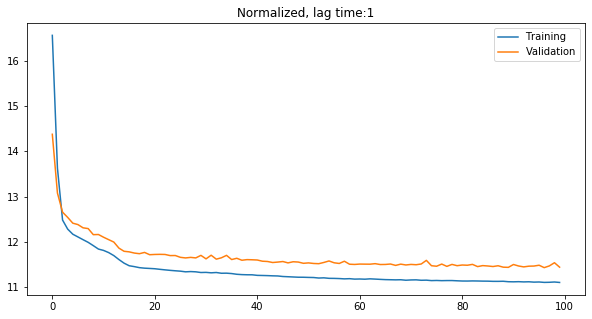

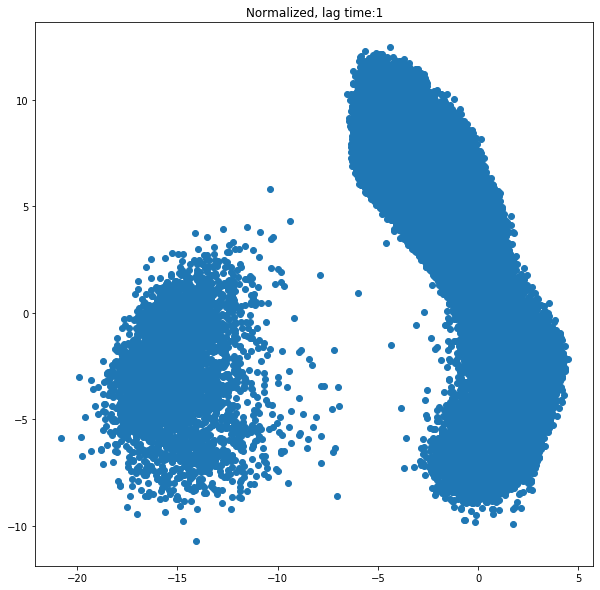

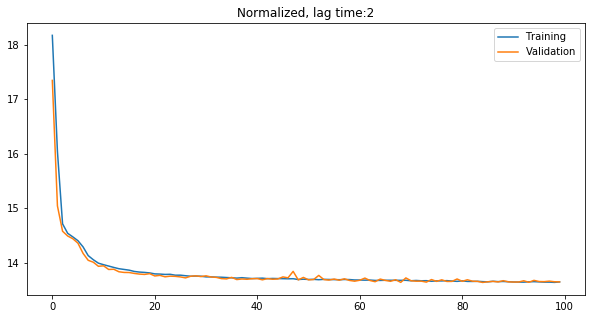

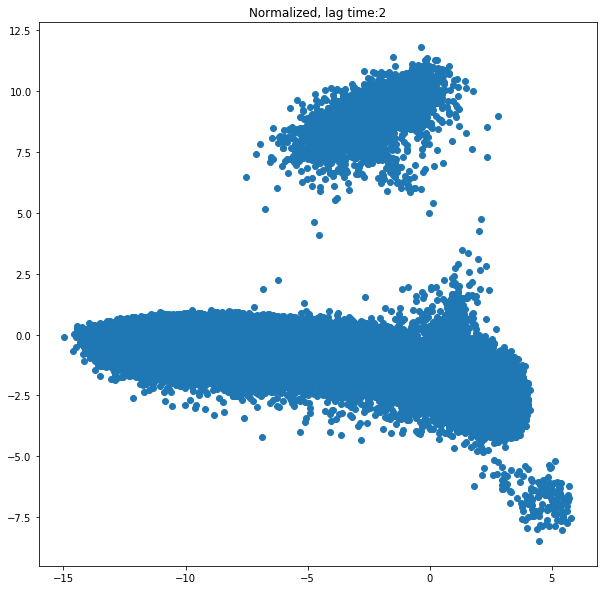

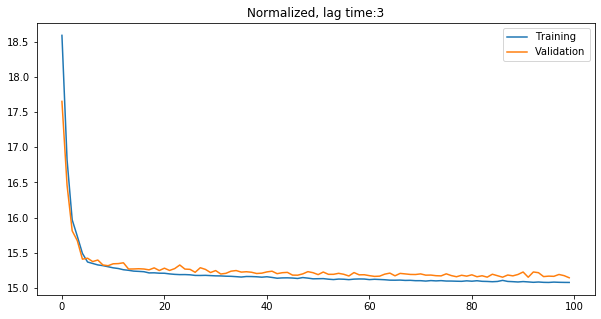

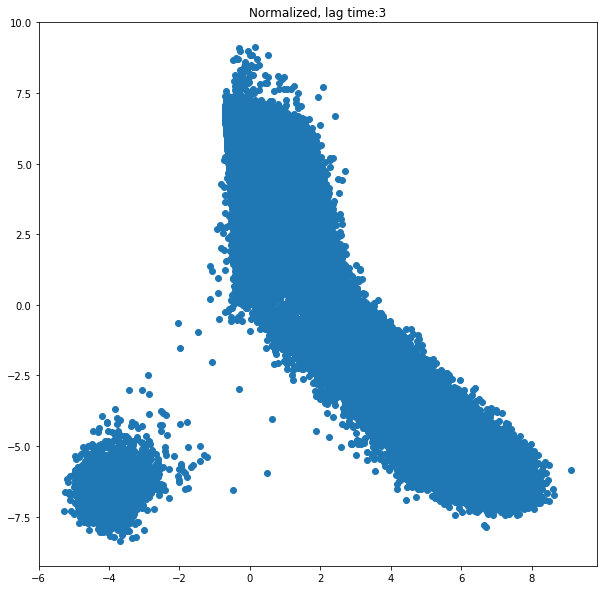

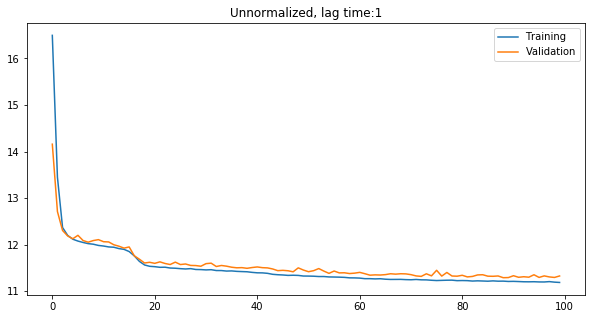

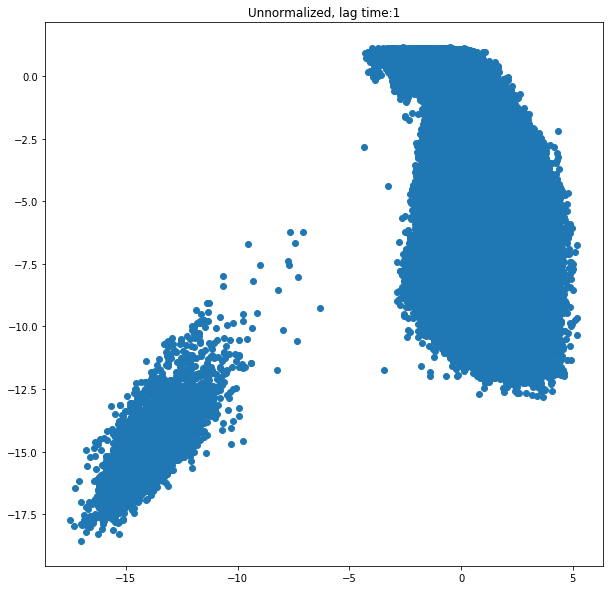

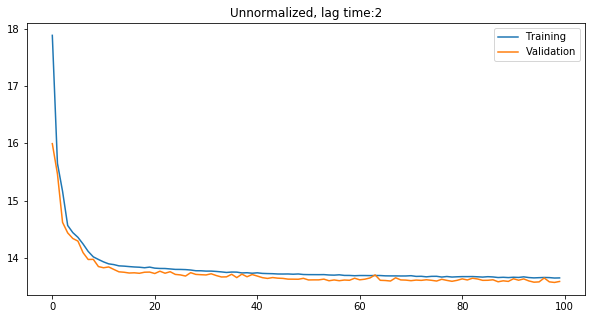

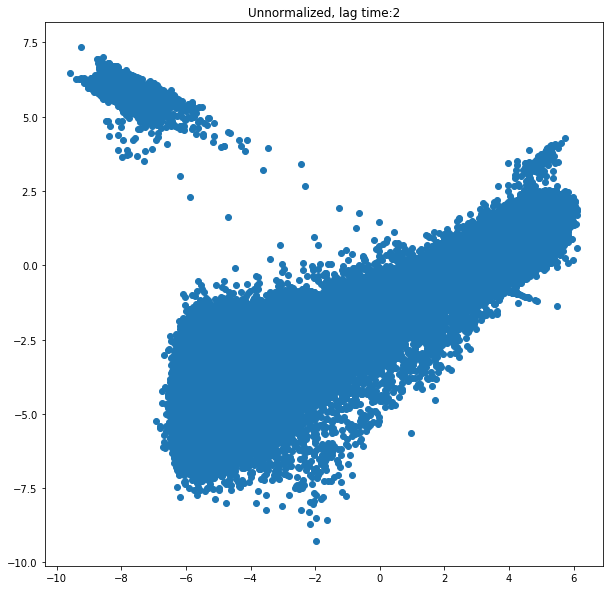

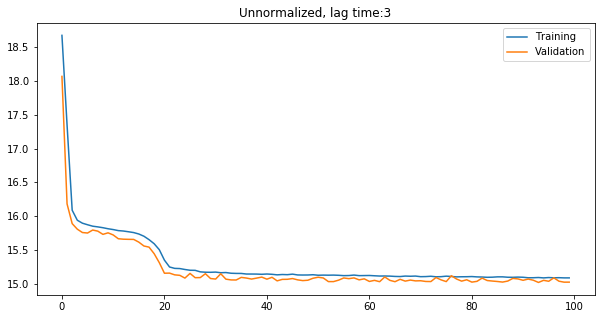

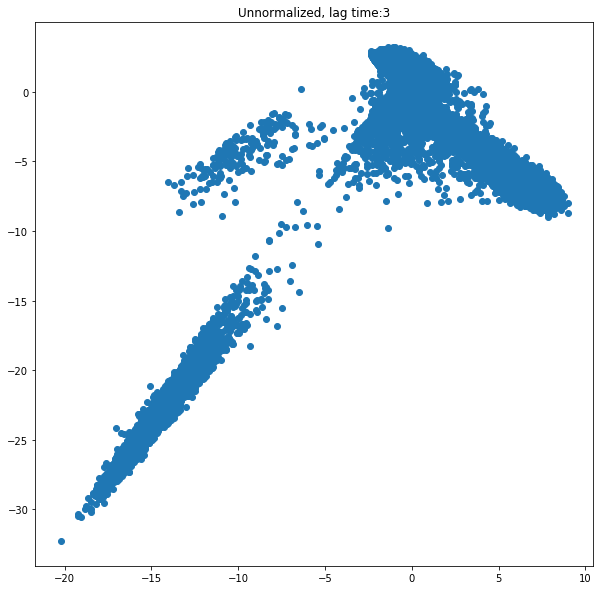

In [228]:
loss_fn = torch.nn.MSELoss(size_average=False)
for key in data_dict:
    multi_train(str(key), data_dict[key])

In [82]:
data = pd.read_csv('../../ala2_.csv')

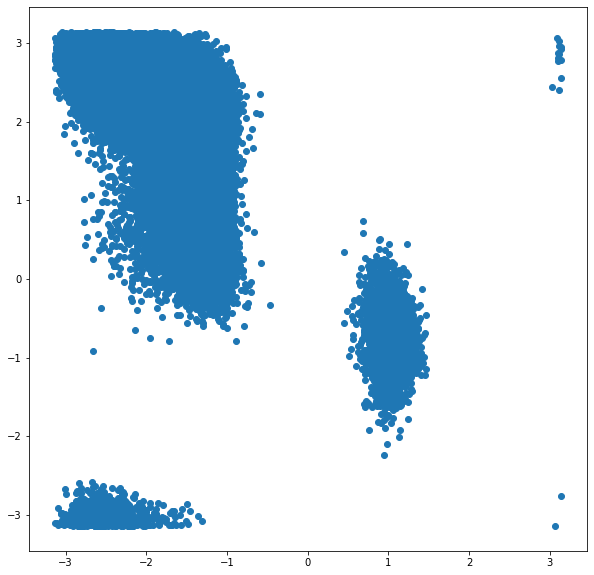

In [84]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(data['phi'], data['psi'])
plt.show()
#fig.savefig('reduced.png', dpi=200)